# UPDRS

Create long UPDRS (1/2/3OFF/4) records     
SDR and LDR recoreds    

New variables;
* DRT_ON: DRT (Levodopa and Doapmin) usage and ON/OFF status. NonUser, ON, OFF, Unknown.
* Vord: Visit order. (SC = -1, BL = 0, V01=1, V02=2, ...). Only available for the planned visits
* PDMED: Originally 'PD_MED_USE': 0=No, 1=Lv, 2=Ag, 3=Oth, 4=1+3, 5=1+2, 6=2+3, 7=1+2+3
* MEDTIME: Hours from the last medication time)

Output files;
1. UPDRS3_SDR.csv: UPDRS3. Paired for ON and OFF observations measured in the same day.
2. UPDRS.csv: All UPDRS in long format. 
    UPDRS3 repeatedly measured at some visits. UPDRS1,2,4 should have the same value for those obs.
    UDPRS3 with DRT_ON==Unknown for visits "V04", "V06", "V08", "V10", "V12", "V13", "V14", "V15" were excluded.
3. UPDRS_4NAreplaced.csv : 
    UPDRS4 values are replaced with 0 if not DRT started and NA in UPDRS4 items.
4. UPDRSmax.csv: The maximum value up to the visit for each items.

In [2]:
library(data.table)
library(dplyr);library(tidyr)
library(zoo)
library(ggplot2);require(gridExtra)
FOLDER = c("PPMI180910")
OUTPUT = c("out180910")
options("width"=130)


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: gridExtra

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [3]:
ref = fread(paste(OUTPUT, "PATNO_EVENTID_DATE.csv", sep="/"),colClasses = c("PATNO"="character"))
dx = fread(paste(OUTPUT, "DEMOG_DIAG.csv", sep="/"), colClasses = c("PATNO"="character")) %>% select(PATNO, DIAG)
dxPD = dx %>% filter(grepl("iPD_stable_YsImg_", DIAG)) %>% distinct(PATNO)
dxPD_PPMI = dx %>% filter(grepl("iPD_stable_YsImg_PPMI", DIAG)) %>% distinct(PATNO)
med = fread("out180910/MED_INIT.csv",  colClasses = c("PATNO"="character"))
init=fread(paste(OUTPUT, "MED_INIT.csv", sep ="/"), colClasses = c("PATNO"="character"))
Visits = c("SC", "BL", sprintf("%s%02d", "V", 1:20)) # Give values for ordinary visits
se <- function(x){sqrt(var(x)/length(x))}

read_func <- function(file, string){
  data = fread(paste(FOLDER, file, sep='/'), header = T, quote="\"", colClasses = c("PATNO"="character")) %>%
    na_if("") %>%
    mutate_at(vars(starts_with(string)), funs(as.numeric)) %>% 
    select(PATNO, EVENT_ID, grep(string, colnames(.))) %>%
    left_join(., ref, by=c("PATNO", "EVENT_ID")) %>% 
    filter(!is.na(PATNO))
}

read_func2 <- function(file, vecs_str){
  data = fread(paste(FOLDER, file, sep='/'), header = T, quote="\"", colClasses = c("PATNO"="character")) %>%
    na_if("") %>%
    mutate_at(vars(vecs_str), funs(as.numeric)) %>% 
    select(PATNO, EVENT_ID, vecs_str) %>%
    left_join(., ref, by=c("PATNO", "EVENT_ID")) %>% 
    filter(!is.na(PATNO))
}

read_func3 <- function(file, string){
  data = fread(paste(FOLDER, file, sep='/'), header = T, quote="\"", colClasses = c("PATNO"="character")) %>%
    na_if("") %>%
    mutate_at(vars(starts_with(string)), funs(as.numeric)) %>% 
    mutate(MEDTIME = as.numeric(ANNUAL_TIME_BTW_DOSE_NUPDRS),
           ON = if_else(ON_OFF_DOSE==2, 1, 0),
           HY = as.numeric(NHY),
           PDMED = PD_MED_USE) %>%
    select(PATNO, EVENT_ID, grep(string, colnames(.)), HY, MEDTIME,ON, PDMED) %>%
    left_join(., ref, by=c("PATNO", "EVENT_ID")) %>% 
    filter(!is.na(PATNO))
}

In [4]:
# UPDRS
temp1 = read_func('MDS_UPDRS_Part_I.csv', 'NP1')
cat("check duplicated obs in the same day for UPDRS part I (dup>1)")
temp1 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(dup))
temp2 = read_func('MDS_UPDRS_Part_I__Patient_Questionnaire.csv', 'NP1')
cat("Check duplicated obs in the same event-id for UPDRS part I-quationnaire (dup>1)")
temp2 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(dup))
temp3 = read_func('MDS_UPDRS_Part_II__Patient_Questionnaire.csv', 'NP2')
cat("check duplicated obs in the same event-id for UPDRS part II (dup>1)")
temp3 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(dup))
temp5 = read_func('MDS_UPDRS_Part_IV.csv', 'NP4')
cat("check duplicated obs in the same event-id for UPDRS part IV (dup>1)")
temp5 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(dup))
temp4 = read_func3('MDS_UPDRS_Part_III.csv', 'NP3') # "NP3RIGRL"
cat("check duplicated obs in the same event-id for UPDRS part III (dup>1)")
temp4 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(dup))
temp4 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% with(table(EVENT_ID, dup))
cat("UPDRS3 has duplicated observations at the same visits,
(BL(GENPD), 4,6,8,10,12,13,14,15: If the participant was taking DRT, UPDRS3 was measured 1 hour after medication)
For duplicated observations, (dup==2), On/Off label (ON==1/0) is available at the most of the time (Below)")
temp4_dup = temp4 %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% 
    filter(dup>1) 
temp4_dup %>% with(table(EVENT_ID, ON, useNA = 'always'))

check duplicated obs in the same day for UPDRS part I (dup>1)

dup
    1 
11348 

Check duplicated obs in the same event-id for UPDRS part I-quationnaire (dup>1)

dup
    1 
11347 

check duplicated obs in the same event-id for UPDRS part II (dup>1)

dup
    1 
11347 

check duplicated obs in the same event-id for UPDRS part IV (dup>1)

dup
   1 
4582 

check duplicated obs in the same event-id for UPDRS part III (dup>1)

dup
   1    2 
9858 2974 

        dup
EVENT_ID    1    2
     BL  1664  294
     PW     8    4
     RS1    4    0
     SC  1098    0
     ST   205    0
     U01    3    0
     V01  507    0
     V02  887    4
     V03  452    4
     V04  834  466
     V05  789   22
     V06  785  504
     V07  585    4
     V08  482  468
     V09  488    4
     V10  355  486
     V11  326    2
     V12  271  396
     V13   58  226
     V14   56   88
     V15    1    2

UPDRS3 has duplicated observations at the same visits,
(BL(GENPD), 4,6,8,10,12,13,14,15: If the participant was taking DRT, UPDRS3 was measured 1 hour after medication)
For duplicated observations, (dup==2), On/Off label (ON==1/0) is available at the most of the time (Below)

        ON
EVENT_ID   0   1 <NA>
    BL   121 165    8
    PW     0   0    4
    V02    1   2    1
    V03    2   2    0
    V04  207 254    5
    V05    8  10    4
    V06  220 270   14
    V07    1   1    2
    V08  216 243    9
    V09    1   1    2
    V10  225 248   13
    V11    0   0    2
    V12  194 197    5
    V13  108 115    3
    V14   38  48    2
    V15    1   1    0
    <NA>   0   0    0

In [6]:
cat("From the following step, we crete DRT_ON labels for UPDRS3.
PDMED (Medication at the measurement) label for the duplicated observations")
temp4_dup %>% with(table(PDMED, ON, useNA = 'always'))
cat("PDMED is originally 'PD_MED_USE': 0=No, 1=Lv, 2=Ag, 3=Oth, 4=1+3, 5=1+2, 6=2+3, 7=1+2+3
If PDMED == 0 (no anti-PD medication) or 3 (Other than levodopa or DA), DRT_ON will be labeled as 'NonUser'.
Other ON==NA obs will be excluded.")
temp4_dup_filtered = temp4_dup %>%
    mutate(DRT_ON=ifelse(ON==1, "ON", "OFF")) %>%
    mutate(DRT_ON = ifelse( PDMED %in% c(0,3), "NonUser", DRT_ON)) %>%
    filter(!( is.na(DRT_ON) ))
temp4_dup_filtered %>% with(table(PDMED, DRT_ON, useNA = 'always'))
cat("ON/OFF per event_ID for duplicated observations (filtered)")
temp4_dup_filtered %>% with(table(EVENT_ID, DRT_ON, useNA = 'always'))

From the following step, we crete DRT_ON labels for UPDRS3.
PDMED (Medication at the measurement) label for the duplicated observations

      ON
PDMED    0   1 <NA>
  0      1   0   12
  1    525 595   20
  2     95 107    4
  3      8  18   19
  4    247 270    5
  5    164 196    4
  6    108 123    1
  7    195 248    9
  <NA>   0   0    0

PDMED is originally 'PD_MED_USE': 0=No, 1=Lv, 2=Ag, 3=Oth, 4=1+3, 5=1+2, 6=2+3, 7=1+2+3
If PDMED == 0 (no anti-PD medication) or 3 (Other than levodopa or DA), DRT_ON will be labeled as 'NonUser'.
Other ON==NA obs will be excluded.

      DRT_ON
PDMED  NonUser OFF  ON <NA>
  0         13   0   0    0
  1          0 525 595    0
  2          0  95 107    0
  3         45   0   0    0
  4          0 247 270    0
  5          0 164 196    0
  6          0 108 123    0
  7          0 195 248    0
  <NA>       0   0   0    0

ON/OFF per event_ID for duplicated observations (filtered)

        DRT_ON
EVENT_ID NonUser OFF  ON <NA>
    BL         6 120 163    0
    V02        0   1   2    0
    V03        0   2   2    0
    V04       14 204 247    0
    V05        0   8  10    0
    V06       18 217 264    0
    V07        2   0   1    0
    V08        8 215 240    0
    V09        0   1   1    0
    V10        6 225 248    0
    V12        2 194 197    0
    V13        0 108 115    0
    V14        2  38  48    0
    V15        0   1   1    0
    <NA>       0   0   0    0

Looking at the table above, the number of ON and OFF are different for duplicated observations
Some people had both obs with ON==1 or ON==0 in the same event rather than having obs with ON==1 and ON==0.
Table of duplicated observations for (PATNO, EVENT_ID, and ON/OFF status) per visit

        DRT_ON
EVENT_ID NonUser OFF ON <NA>
    BL         6   0 44    0
    V04       14   2 44    0
    V06       18   2 48    0
    V07        2   0  0    0
    V08        8   4 24    0
    V10        6   0 22    0
    V12        2   0  4    0
    V13        0   0  4    0
    V14        2   0 10    0
    <NA>       0   0  0    0

This is OK for longitudinal analyses. For the analysis of short drug responses of LD, 
we will extract paired observations with ON==1 and OFF=0 at the same visit from those using levodopa.
Note: 
For the first filteration, we excluded ON==NA observations and recoded some of them, 
so some observations are not paired any more. exclude these orphan observations too.

        DRT_ON
EVENT_ID OFF  ON <NA>
    BL   102 102    0
    V02    1   1    0
    V04  148 148    0
    V05    4   4    0
    V06  168 168    0
    V08  183 183    0
    V09    1   1    0
    V10  201 201    0
    V12  176 176    0
    V13  103 103    0
    V14   36  36    0
    V15    1   1    0
    <NA>   0   0    0

Save this file for SDR analysis.
Look at the relationship between ON/OFF dichotomization and MEDTIME for this SDR file.
NOTE:MEDTIME (hours from the last medication time)

              DRT_ON
PDMED_Interval  OFF   ON <NA>
     < 6 hour     0 1124    0
     >= 6 hour 1124    0    0
     <NA>         0    0    0

ON/OFF and MEDTIME summary

DRT_ON,min,mean,median,max
OFF,6,14.588113,13.8333,99.0000
ON,0,1.473766,1.2000,5.6667


MEDTIME<6 can perfectly separat ON/OFF.

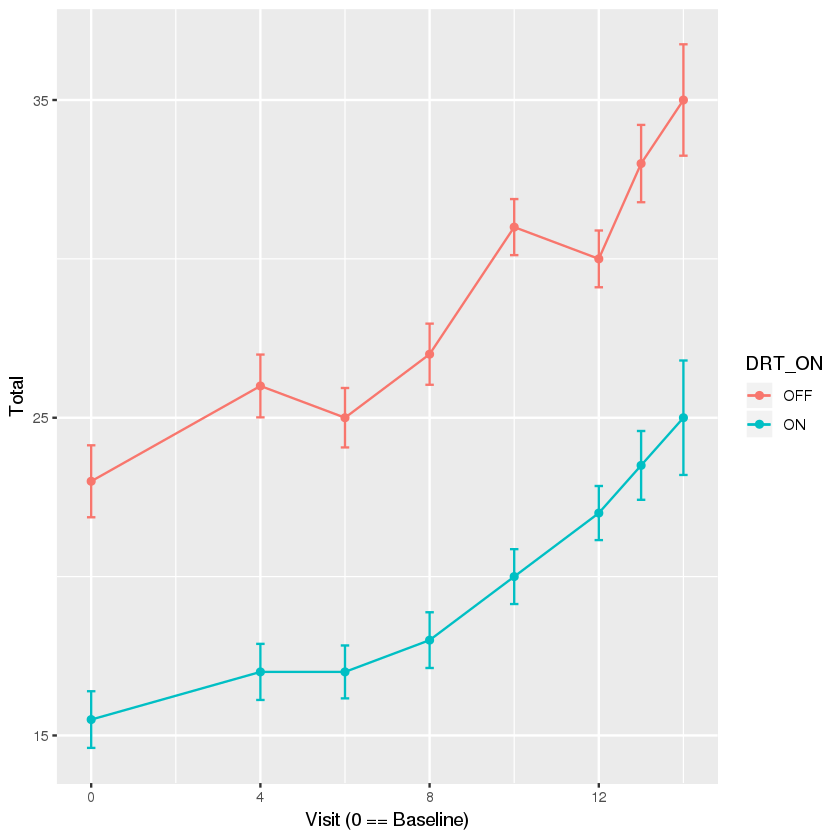

In [7]:
cat("Looking at the table above, the number of ON and OFF are different for duplicated observations
Some people had both obs with ON==1 or ON==0 in the same event rather than having obs with ON==1 and ON==0.
Table of duplicated observations for (PATNO, EVENT_ID, and ON/OFF status) per visit")
temp4_dup_filtered %>% group_by(PATNO, EVENT_ID, DRT_ON) %>% mutate(dup=n()) %>% 
    filter(dup>1) %>% with(table(EVENT_ID, DRT_ON, useNA = 'always'))
cat("This is OK for longitudinal analyses. For the analysis of short drug responses of LD, 
we will extract paired observations with ON==1 and OFF=0 at the same visit from those using levodopa.
Note: 
For the first filteration, we excluded ON==NA observations and recoded some of them, 
so some observations are not paired any more. exclude these orphan observations too.")
temp4_dup_SDR = temp4_dup_filtered %>% filter(PDMED %in% c(1,4,5,7)) %>%
    group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% filter(dup>1) %>% ungroup %>%
    group_by(PATNO, EVENT_ID, DRT_ON) %>% mutate(dup=n()) %>% filter(dup==1) %>% ungroup
temp4_dup_SDR %>% with(table(EVENT_ID, DRT_ON, useNA = 'always'))
cat("Save this file for SDR analysis.\n")
temp4_dup_SDR %>% write.csv(. , paste(OUTPUT, "UPDRS3_SDR.csv", sep="/"))
cat("Look at the relationship between ON/OFF dichotomization and MEDTIME for this SDR file.
NOTE:MEDTIME (hours from the last medication time)")
temp4_dup_SDR %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% 
    filter(dup>1) %>% mutate(PDMED_Interval=ifelse(MEDTIME<6, '< 6 hour', ">= 6 hour")) %>% 
    with(table(PDMED_Interval, DRT_ON, useNA = 'always'))
cat("ON/OFF and MEDTIME summary")
temp4_dup_SDR %>% group_by(PATNO, EVENT_ID) %>% mutate(dup=n()) %>% 
    filter(dup>1) %>% ungroup %>% group_by(DRT_ON) %>% summarise_at(vars("MEDTIME"), funs(min, mean, median, max))
cat("MEDTIME<6 can perfectly separat ON/OFF.")
temp4_dup_SDR %>% 
  mutate(CAT = DRT_ON) %>% 
  mutate(Vord = as.numeric(factor(EVENT_ID, levels=Visits))-2) %>%
  data.frame %>% filter( Vord %%1==0 | Vord==-1) %>% 
  mutate(TOTAL = rowSums(.[,grep("NP", names(.))])) %>% filter(!is.na(TOTAL)) %>%
  group_by(CAT, Vord) %>% summarise_at(vars("TOTAL"), funs(mean=median, se, n())) %>% filter(n>10) %>% 
  ungroup %>% arrange(CAT, Vord)   %>% filter(complete.cases(.)) %>%
  mutate(DRT_ON = CAT) %>%
  ggplot + aes(Vord, mean, colour=DRT_ON) +
  geom_line(aes(group=CAT)) + geom_point() + 
  geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.2) + 
  scale_x_continuous(breaks = seq(0, 16, by = 4)) + 
  scale_y_continuous(breaks = seq(15, 46, by = 10)) + 
  ylab("Total") + xlab("Visit (0 == Baseline)")

In [8]:
cat("Analyze non-duplicated observations")
temp4_noDup = anti_join(temp4, temp4_dup, by=c("PATNO", "EVENT_ID"))
temp4_noDup %>% with(table(PDMED, ON, useNA = 'always'))
temp4_noDup %>% with(table(EVENT_ID, ON, useNA = 'always'))
cat("If PDMED==0, or 3, DRT_ON as 'NonUser' regardless of ON values.
The NA in ON values will be coded as DRT_ON=='Unknown' otherwise.
They are taking Levodopa and/or DA but the status is unknown.")
temp4_noDup_recoded = temp4_noDup %>% 
    mutate(DRT_ON=ifelse(ON==1, "ON", "OFF")) %>%
    mutate(DRT_ON=ifelse((PDMED %in% c(0,3)), 'NonUser', DRT_ON)) %>%
    mutate(DRT_ON=ifelse(is.na(DRT_ON), 'Unknown', DRT_ON))
temp4_noDup_recoded %>% with(table(PDMED, DRT_ON, useNA = 'always'))
temp4_noDup_recoded %>% with(table(EVENT_ID, DRT_ON, useNA = 'always'))
temp4_noDup_recoded %>% mutate(PDMED_Interval=ifelse(MEDTIME<6, '< 6 hour', ">= 6 hour")) %>% 
    with(table(PDMED_Interval, ON, useNA = 'always'))
cat("ON ==NA obs also don't have MEDTIME information. So we cannot label ON/OFF status based on MEDTIME")

Analyze non-duplicated observations

      ON
PDMED     0    1 <NA>
  0       0    0 6753
  1      42  277  643
  2      36  114  236
  3       1    5  520
  4      12  124  275
  5      16   75  199
  6      17   51  158
  7      11   94  199
  <NA>    0    0    0

        ON
EVENT_ID    0    1 <NA>
    BL     29  162 1473
    PW      0    0    8
    RS1     0    0    4
    SC      0    0 1098
    ST      0    0  205
    U01     0    0    3
    V01     0    0  507
    V02     0    0  887
    V03     0    0  452
    V04    13   93  728
    V05     0    1  788
    V06    33  148  604
    V07     0    0  585
    V08    25  125  332
    V09     0    0  488
    V10    14   85  256
    V11     0    0  326
    V12    14   79  178
    V13     5   40   13
    V14     2    7   47
    V15     0    0    1
    <NA>    0    0    0

If PDMED==0, or 3, DRT_ON as 'NonUser' regardless of ON values.
The NA in ON values will be coded as DRT_ON=='Unknown' otherwise.
They are taking Levodopa and/or DA but the status is unknown.

      DRT_ON
PDMED  NonUser  OFF   ON Unknown <NA>
  0       6753    0    0       0    0
  1          0   42  277     643    0
  2          0   36  114     236    0
  3        526    0    0       0    0
  4          0   12  124     275    0
  5          0   16   75     199    0
  6          0   17   51     158    0
  7          0   11   94     199    0
  <NA>       0    0    0       0    0

        DRT_ON
EVENT_ID NonUser  OFF   ON Unknown <NA>
    BL      1472   28  158       6    0
    PW         6    0    0       2    0
    RS1        4    0    0       0    0
    SC      1096    0    0       2    0
    ST       205    0    0       0    0
    U01        3    0    0       0    0
    V01      499    0    0       8    0
    V02      696    0    0     191    0
    V03      327    0    0     125    0
    V04      727   13   93       1    0
    V05      439    0    1     349    0
    V06      604   33  147       1    0
    V07      210    0    0     375    0
    V08      332   25  125       0    0
    V09      131    0    0     357    0
    V10      249   14   85       7    0
    V11       41    0    0     285    0
    V12      178   14   79       0    0
    V13       12    5   40       1    0
    V14       47    2    7       0    0
    V15        1    0    0       0    0
    <NA>       0    0    0       0    0

              ON
PDMED_Interval    0    1 <NA>
     < 6 hour     0  739    0
     >= 6 hour  131    1    0
     <NA>         4    0 8983

ON ==NA obs also don't have MEDTIME information. So we cannot label ON/OFF status based on MEDTIME

Combine duplicated observations (After ON=NA is filtered) and non-duplicated observations

         ON
DRT_ON       0    1 <NA>
  NonUser   10   23 7304
  OFF     1468    0    0
  ON         0 2274    0
  Unknown    0    0 1710
  <NA>       0    0    0

        DRT_ON
EVENT_ID NonUser  OFF   ON Unknown <NA>
    BL      1478  148  321       6    0
    PW         6    0    0       2    0
    RS1        4    0    0       0    0
    SC      1096    0    0       2    0
    ST       205    0    0       0    0
    U01        3    0    0       0    0
    V01      499    0    0       8    0
    V02      696    1    2     191    0
    V03      327    2    2     125    0
    V04      741  217  340       1    0
    V05      439    8   11     349    0
    V06      622  250  411       1    0
    V07      212    0    1     375    0
    V08      340  240  365       0    0
    V09      131    1    1     357    0
    V10      255  239  333       7    0
    V11       41    0    0     285    0
    V12      180  208  276       0    0
    V13       12  113  155       1    0
    V14       49   40   55       0    0
    V15        1    1    1       0    0
    <NA>       0    0    0       0    0

So on visits 4,6,8,10,12-15, most of the visits are now labeled. 
DRT_ON == 'Unknown' will be excluded for these visits. 
For other visit, DRT_ON/OFF status is not defined for many cases

Obs from PPMI PD cohorts

        DRT_ON
EVENT_ID NonUser OFF  ON Unknown <NA>
    BL       418   0   0       0    0
    PW         2   0   0       1    0
    SC       441   0   0       0    0
    ST       194   0   0       0    0
    U01        2   0   0       0    0
    V01      374   0   0       5    0
    V02      259   0   0      18    0
    V03      214   1   1     113    0
    V04      203 102 155       0    0
    V05      150   6   8     203    0
    V06      115 157 234       0    0
    V07       85   0   1     271    0
    V08       68 182 271       0    0
    V09       51   1   1     291    0
    V10       39 206 288       0    0
    V11       33   0   0     274    0
    V12       25 203 267       0    0
    V13        8 111 153       0    0
    V14        6  40  55       0    0
    V15        0   1   1       0    0
    <NA>       0   0   0       0    0

Plot for UPDRS3 total based on DRT_ON status.
DRT_ON==Unknown is between DRT_ON/OFF.
Note: These groups are not having consitent membership. 
e.g. More NonUser joined the group for users as time goes by.

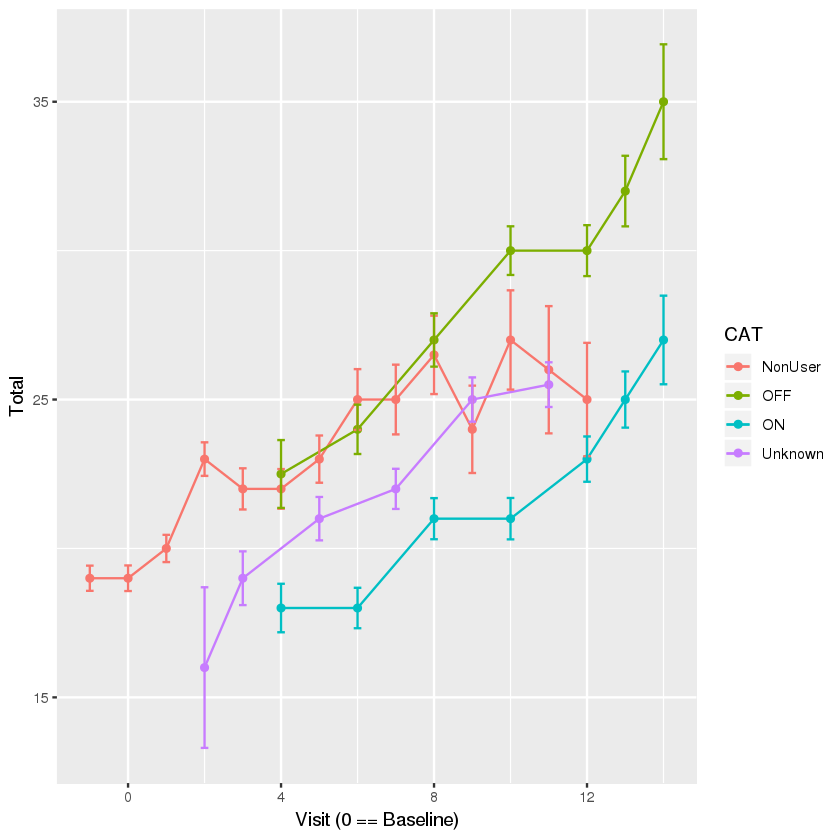

In [9]:
cat("Combine duplicated observations (After ON=NA is filtered) and non-duplicated observations")
temp4_combined = bind_rows(temp4_dup_filtered, temp4_noDup_recoded) %>% select(-dup)
temp4_combined %>% with(table(DRT_ON, ON, useNA = 'always'))
temp4_combined %>% with(table(EVENT_ID, DRT_ON, useNA = 'always'))
cat("So on visits 4,6,8,10,12-15, most of the visits are now labeled. 
DRT_ON == 'Unknown' will be excluded for these visits. 
For other visit, DRT_ON/OFF status is not defined for many cases\n")
temp4_combined_limited = temp4_combined %>% 
    filter(!(EVENT_ID %in% c("V04", "V06", "V08", "V10", "V12", "V13", "V14", "V15") & DRT_ON=="Unknown"))
cat("\nObs from PPMI PD cohorts")
temp4_combined_limited %>% 
  inner_join(., dx, by="PATNO") %>% filter(grepl("iPD_stable_YsImg_PPMI", DIAG)) %>%
  with(table(EVENT_ID, DRT_ON, useNA = 'always'))
temp4_combined_limited %>% 
  inner_join(., dx, by="PATNO") %>% filter(grepl("iPD_stable_YsImg_PPMI", DIAG)) %>%
  mutate(CAT = as.character(DRT_ON)) %>% 
#   mutate(CAT=ON3) %>%
  mutate(Vord = as.numeric(factor(EVENT_ID, levels=Visits))-2) %>%
  data.frame %>% filter( Vord %%1==0 | Vord==-1) %>% 
  mutate(TOTAL = rowSums(.[,grep("NP", names(.))])) %>% filter(!is.na(TOTAL)) %>%
  group_by(CAT, Vord) %>% summarise_at(vars("TOTAL"), funs(mean=median, se, n())) %>% filter(n>10) %>% 
  ungroup %>% arrange(CAT, Vord)   %>% filter(complete.cases(.)) %>%
  ggplot + aes(Vord, mean, colour=CAT) +
  geom_line(aes(group=CAT)) + geom_point() + 
  geom_errorbar(aes(ymin=mean-se, ymax=mean+se), width=.2) + 
  scale_x_continuous(breaks = seq(0, 16, by = 4)) + 
  scale_y_continuous(breaks = seq(15, 46, by = 10)) + 
  ylab("Total") + xlab("Visit (0 == Baseline)")
cat("Plot for UPDRS3 total based on DRT_ON status.
DRT_ON==Unknown is between DRT_ON/OFF.
Note: These groups are not having consitent membership. 
e.g. More NonUser joined the group for users as time goes by.")

In [10]:
cat("Combine UPDRS1, 2,3(processed), 4, all together and set the baseline.
Note: Baseline were created like LOCF method using SC and BL visits\n")
UPDRS = full_join(temp1, temp2, by=c("PATNO", "EVENT_ID", "DATE")) %>% 
  full_join(., temp3, by=c("PATNO", "EVENT_ID", "DATE")) %>% 
  full_join(., temp4_combined_limited, by=c("PATNO", "EVENT_ID", "DATE")) %>% 
  full_join(., temp5, by=c("PATNO", "EVENT_ID", "DATE")) %>% 
  mutate(num_na = rowSums(is.na(.))) %>% # Count the missing obs per visit
  mutate(Vord = as.numeric(factor(EVENT_ID, levels=Visits))-2)

items = c(names(UPDRS)[grep('NP', names(UPDRS))], "HY")
items_NP1 = names(UPDRS)[grep('NP1', names(UPDRS))]
items_NP2 = names(UPDRS)[grep('NP2', names(UPDRS))]
items_NP3 = names(UPDRS)[grep('NP3', names(UPDRS))]
items_NP4 = names(UPDRS)[grep('NP4', names(UPDRS))]

cat("\nCROSS-TAB: Ordinary visit orders and EVENT_IDs")
UPDRS %>% with(table(Vord, EVENT_ID, useNA = 'always'))

setBL_func = function(data){
  BL = data %>% filter(Vord <= 0) %>% #SC and . BL
    arrange(Vord) %>% 
    group_by(PATNO) %>% 
    #LOCF for NAs in the UPDRS items for BL if SC is available
    mutate_at(vars(items),funs(na.locf(., na.rm=F))) %>% 
    ungroup%>% 
    arrange(desc(Vord)) %>%  
    distinct(PATNO, .keep_all = T) %>% # Keep the latest date among BL or SC
    ungroup %>% 
    mutate(Vord=-0.1)  
  data %>% filter(is.na(Vord) | Vord>0) %>% 
    bind_rows(BL, .)
}


# UPDRS = setBL_func(UPDRS)
# cat("CROSS-TAB: After reducing baseline (Vord==-0.1) per indiidual")
# UPDRS %>% with(table(Vord, EVENT_ID, useNA = 'always'))

Combine UPDRS1, 2,3(processed), 4, all together and set the baseline.
Note: Baseline were created like LOCF method using SC and BL visits

CROSS-TAB: Ordinary visit orders and EVENT_IDs

      EVENT_ID
Vord     BL   PW  RS1   SC   ST  U01  V01  V02  V03  V04  V05  V06  V07  V08  V09  V10  V11  V12  V13  V14  V15 <NA>
  -1      0    0    0 1101    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  0    1955    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1       0    0    0    0    0    0  507    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2       0    0    0    0    0    0    0  891    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  3       0    0    0    0    0    0    0    0  457    0    0    0    0    0    0    0    0    0    0    0    0    0
  4       0    0    0    0    0    0    0    0    0 1301    0    0    0    0    0    0    0    0    0    0    0    0
  5       0    0    0    0    0    0    0    0    0    0  809    0    0    0    0    0    0    0    0    0    0    0
  6       0    0    0    0    0    0    0    0   

In [23]:
UPDRS %>% write.csv(., paste(OUTPUT, "UPDRS.csv", sep='/'), row.names = F)
UPDRS %>% filter(EVENT_ID %in% Visits) %>% with(table(num_na, EVENT_ID)) %>% addmargins(.)
cat("The index numbers correspond to the number of missing values in UPDRS items + HY + MEDTIME + ON. 
2: missing MEDTIME and ON.
8: missing UPDRS4
Note UPDRS4 is only eveluated after PD medication initiation.
Check how many UPDRS4 are missing per visit X PDMED\n")
cat("Following data replacement is conducted.
PDMED==0 or 3, -> NA in UPDRS4 items are replaced with 0")
UPDRS %>% filter(is.na(NP4WDYSK)) %>% with(table(EVENT_ID, PDMED))
UPDRS_processed = UPDRS %>% mutate_at(vars(items_NP4), funs(ifelse(PDMED %in% c(0,3), replace_na(., 0), .))) %>%
    select(-num_na) %>%
    mutate(num_na = rowSums(is.na(.))) # Count the missing obs per visit
UPDRS_processed %>% filter(EVENT_ID %in% Visits) %>% with(table(num_na, EVENT_ID)) %>% addmargins(.)
cat("Also save this processed version of UPDRS")
UPDRS_processed %>% select(-num_na) %>% write.csv(., paste(OUTPUT, "UPDRS_4NAreplaced.csv", sep="/"))

,BL,SC,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,Sum
0,416,0,0,3,4,555,19,644,2,593,2,558,0,478,266,91,2,3633
1,2,0,0,0,0,0,0,5,0,1,0,2,0,4,0,4,0,18
2,76,38,20,201,152,86,407,92,422,56,385,41,296,22,6,0,0,2300
3,0,0,0,0,0,0,1,0,2,0,3,0,1,2,0,0,0,9
4,0,0,1,0,0,0,0,0,1,0,1,2,0,0,0,0,0,5
5,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2
6,56,0,0,0,0,9,0,16,0,9,0,6,0,0,0,0,0,96
7,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,4
8,1393,1052,482,682,297,640,375,515,155,281,93,215,27,157,8,48,1,6421
9,2,3,0,1,2,2,0,3,1,2,0,0,0,1,0,0,0,17


The index numbers correspond to the number of missing values in UPDRS items + HY + MEDTIME + ON. 
2: missing MEDTIME and ON.
8: missing UPDRS4
Note UPDRS4 is only eveluated after PD medication initiation.
Check how many UPDRS4 are missing per visit X PDMED
Following data replacement is conducted.
PDMED==0 or 3, -> NA in UPDRS4 items are replaced with 0

        PDMED
EVENT_ID    0    1    2    3    4    5    6    7
     BL  1396   10    1    5   15    9    1   20
     PW     3    0    0    0    0    0    0    0
     RS1    4    0    0    0    0    0    0    0
     SC  1058    1    0    0    0    1    0    0
     ST   198    0    0    1    0    0    0    0
     U01    1    0    0    0    0    0    0    0
     V01  485    0    1    0    0    0    0    0
     V02  642    7    2    6   12    5    4    8
     V03  275    9    4   10    0    1    0    0
     V04  638    4    1   11    2    0    0    0
     V05  353    9    2   11    1    1    2    1
     V06  511   11    1   12    2    2    0    3
     V07  148    6    1    4    0    0    1    0
     V08  279   10    1    4    0    0    1    0
     V09   91    3    0    0    1    1    0    1
     V10  216    4    0    0    0    2    0    0
     V11   24    1    0    1    0    1    0    0
     V12  156    0    0    2    0    0    0    0
     V13    8    0    0    0    0    0    0    0
     V

,BL,SC,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,Sum
0,420,0,0,3,4,557,19,644,2,593,2,558,0,478,266,91,2,3639
1,2,0,0,0,0,0,0,5,0,1,0,2,0,4,0,4,0,18
2,1468,1088,501,845,435,726,768,607,570,337,472,256,321,179,14,48,1,8636
3,2,3,0,1,2,2,1,1,3,0,3,0,1,3,0,0,0,22
4,0,1,2,0,0,2,2,4,2,1,3,2,0,0,0,0,0,19
5,1,0,0,2,0,1,0,1,3,0,2,0,0,0,0,0,0,10
6,52,0,1,0,0,7,0,16,0,9,1,6,0,0,0,0,0,92
7,0,1,0,0,0,0,0,1,0,1,1,0,2,0,0,0,0,6
8,1,2,2,38,14,1,14,0,7,0,6,0,2,0,0,0,0,87
9,0,0,0,1,0,0,0,2,0,2,0,0,0,0,0,0,0,5


Also save this processed version of UPDRS

# Current maximum UPDRS scores and plotting

In [26]:
cat("Create UPDRS_max dataset, which is the current maxium of each item from the baseline to the obs timepoint.(Only uses ordinally visits)")
takemaxUPDRS_function = function(data, vars){
  FILTERED = data %>% filter(!is.na(Vord)) %>% group_by(PATNO, Vord) %>% mutate(id = row_number()) %>% 
    ungroup %>% arrange(PATNO, Vord, id)
  DATA = FILTERED %>% select(PATNO, vars)
  for (i in 2:nrow(DATA)){
    if(DATA$PATNO[i-1]==DATA$PATNO[i]){
      for (p in 2:ncol(DATA)){
        if(is.na(DATA[i-1,p])){next}
        if(is.na(DATA[i  ,p])){DATA[i, p]=DATA[i-1, p]
        }else if(DATA[i, p]<DATA[(i-1),p]){
          DATA[i,p] = DATA[(i-1),p]
        }
      }
    }
  }
  ans = FILTERED %>% select(-one_of(c("PATNO", vars))) %>% cbind(., DATA) %>% arrange(PATNO, Vord, desc(id)) %>%
    distinct(PATNO, Vord, .keep_all = T) %>% select(-id)
  return(ans)
}

UPDRS_max = takemaxUPDRS_function(UPDRS_processed, items)
write.csv(UPDRS_max, paste(OUTPUT, "UPDRSmax.csv", sep="/"),row.names=F)

Create UPDRS_max dataset, which is the current maxium of each item from the baseline to the obs timepoint.(Only uses ordinally visits)

# Plot chronological trajectory of each person

In [35]:
UPDRS_pd = semi_join(UPDRS_processed, dxPD, by = "PATNO") %>% filter(!is.na(Vord)) %>% 
    mutate(UPDRS1 = rowSums(.[,items_NP1]),
       UPDRS2 = rowSums(.[,items_NP2]),
       UPDRS3 = rowSums(.[,items_NP3]),
       UPDRS4 = rowSums(.[,items_NP4])) %>% 
    arrange(PATNO, Vord, UPDRS3) %>%
    group_by(PATNO) %>% 
    mutate(TSTART = DATE - first(DATE)) %>% ungroup 
UPDRS_pd_max = semi_join(UPDRS_max, dxPD, by="PATNO") %>% filter(!is.na(Vord)) %>%
  mutate(UPDRS1 = rowSums(.[,items_NP1]),
       UPDRS2 = rowSums(.[,items_NP2]),
       UPDRS3 = rowSums(.[,items_NP3]),
       UPDRS4 = rowSums(.[,items_NP4])) %>%
    arrange(PATNO, Vord, UPDRS3) %>%
    group_by(PATNO) %>% 
    mutate(TSTART = DATE - first(DATE)) %>% ungroup 

Warning message:
"Column `PATNO` joining character vector and factor, coercing into character vector"

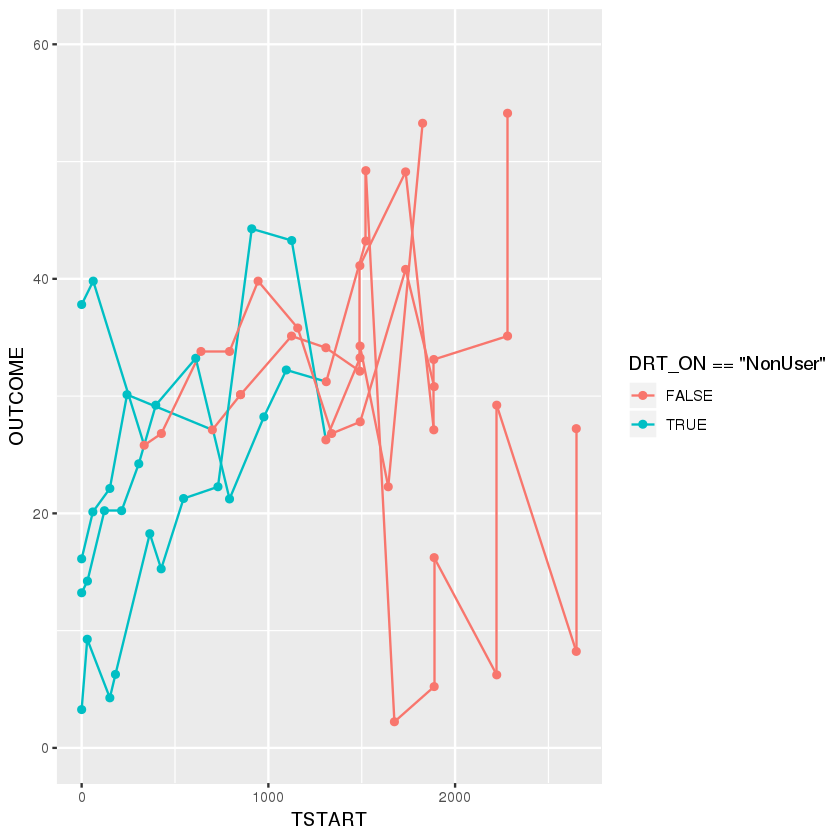

In [49]:
IDs = UPDRS_pd %>% filter(Vord>9) %>% distinct(PATNO) %>% t %>% as.vector %>% sample(., 4)
timeplot_func = function(DATA, ITEM,  IDs){
    ID_jit = data.frame(PATNO=IDs) %>% 
        mutate(j=runif(nrow(.), -0.3, 0.3))
    DATA %>% 
      filter(PATNO %in% IDs) %>% filter(Vord %%1==0) %>%
      mutate(OUTCOME=eval(parse(text = ITEM))) %>% 
      select(PATNO, TSTART, OUTCOME, DRT_ON) %>% 
      left_join(., ID_jit, by="PATNO") %>% 
      mutate(OUTCOME = OUTCOME + j) %>% 
      filter(!(is.na(OUTCOME) & !is.na(TSTART))) %>%
      arrange(PATNO, TSTART, OUTCOME) %>% 
      ggplot + 
#       aes(TSTART, OUTCOME, colour=DRT_ON=="NonUser") + ylim(0, 80)+
      aes(TSTART, OUTCOME, colour=DRT_ON=="NonUser") + ylim(0, 60)+
      geom_line(aes(group=PATNO)) + geom_point()
}
timeplot_func(UPDRS_pd_max, "UPDRS3", IDs)
timeplot_func(UPDRS_pd, "UPDRS3", IDs)